In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import collections

import networkx as nx
from networkx.algorithms import approximation
import seaborn as sns
import plotly.express as px

In [2]:
data_path='saved_files/'

In [3]:
le=pickle.load(open(data_path+'id_LabelEncoder.p', 'rb'))
node_feature=pickle.load(open(data_path+'node_feature.p', 'rb'))
edge_index=pickle.load(open(data_path+'edge_index.p','rb'))

In [4]:
edge_index=pd.merge(edge_index, node_feature[['id','timestamp']], 
         how='left', left_on='patient_id',right_on='id')

In [5]:
demo_of_interest=['name', 'province','city', 'actual_age', 'sex']

def get_measure(timestamp, node_feature, top_k=10):
    #edges so far
    edge_index_time=edge_index.loc[edge_index['timestamp'].dt.days<timestamp, ['infected_by', 'patient_id']]
    elist= edge_index_time.values

    #Creat network
    G = nx.DiGraph()
    G.add_edges_from(elist)

    #Network level summary
    summary_statistics= {'num_nodes':G.number_of_nodes(),
                         'num_edges':G.number_of_edges(),
                        'density':nx.classes.function.density(G),
                       'clustering_coefficient':approximation.average_clustering(G.to_undirected()),
                        'longest_path': nx.algorithms.dag.dag_longest_path_length(G)}

    #Top degree 
    degree_sequence = np.array(sorted([[d,n] for n, d in G.degree() if d>0], reverse=True))  # degree sequence
    summary_statistics['mean_degree']=degree_sequence[:,0].mean()
    high_degree_profiles = pd.DataFrame(degree_sequence, columns=['degree', 'id'])
    node_feature=pd.merge(high_degree_profiles, node_feature, left_on='id', right_on='id')
    #high_degree_profiles_demo = node_feature.sort_values(by='degree', ascending=False).loc[node_feature['name'].apply(lambda x: x.isdigit() ),['degree']+demo_of_interest]

    #Top betweenness
    betweenness=nx.algorithms.centrality.betweenness_centrality(G)
    betweenness_sequence = np.array(sorted([[d,n] for n, d in betweenness.items()], reverse=True))  # degree sequence
    high_betweenness_profiles = pd.DataFrame(betweenness_sequence, columns=['betweenness', 'id'])
    node_feature= pd.merge(node_feature,high_betweenness_profiles,left_on='id', right_on='id')
    #high_betweenness_profiles_demo = node_feature.sort_values(by='betweenness', ascending=False).loc[node_feature['name'].apply(lambda x: x.isdigit() ), ['betweenness']+demo_of_interest]
    node_feature = node_feature.loc[node_feature['name'].apply(lambda x: x.isdigit() ), ['degree','betweenness']+demo_of_interest]
    #return high_degree_profiles_demo.iloc[:top_k, :], high_betweenness_profiles_demo.iloc[:top_k, :], summary_statistics
    #return high_degree_profiles_demo, high_betweenness_profiles_demo, summary_statistics
    return G, elist, node_feature, summary_statistics



## Centrality Plot

In [6]:
dfs=[]
network_summaries=[]
#weekly
time_of_interest=list(range(14,node_feature['timestamp'].max().days,7))
#time_of_interest=range(14,node_feature['timestamp'].max().days)
for time in time_of_interest:
    _,_,node_feature_time,summary_statistics = get_measure(time, node_feature)
    node_feature_time['time']='week'+str(int(time/7))
    dfs.append(node_feature_time)
    
    summary_statistics['time']='week'+str(int(time/7))
    network_summaries.append(summary_statistics)

    
node_feature_time_agg=pd.concat(dfs)
network_summaries=pd.DataFrame(network_summaries)
#network_summaries['time']=time_of_interest# range(14,63)

Sex and centrality

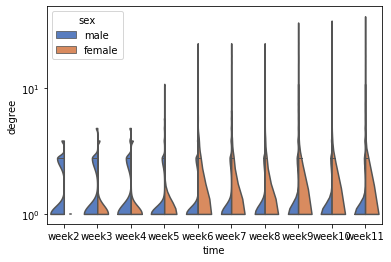

In [7]:
g= sns.violinplot(x='time', 
               y='degree',
               data=node_feature_time_agg.loc[node_feature_time_agg['degree']>0,:],
              hue='sex', scale='count', cut=0,
              palette='muted', split=True, inner='stick', bw=.2)
g.set_yscale("symlog")

fig=g.get_figure()
fig.savefig("plots/degree-sex.png", dpi=300)

In [8]:
#node_feature_time_agg.loc[node_feature_time_agg['time']=='week11'].sort_values(by='betweenness', ascending=False)

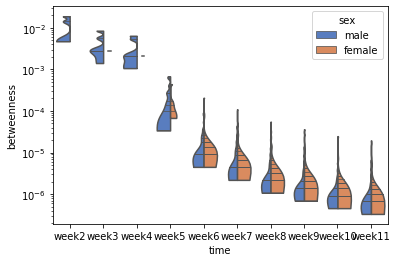

In [9]:
g= sns.violinplot(x='time', 
               y='betweenness',
               data=node_feature_time_agg.loc[node_feature_time_agg['betweenness']>0,:],
              hue='sex', scale='count',cut=1e-6,
              palette='muted', split=True, inner='stick', bw=.2)
g.set_yscale("log")

fig=g.get_figure()
fig.savefig("plots/betweenness-sex.png", dpi=300)

In [10]:
network_summaries

,num_nodes,num_edges,density,clustering_coefficient,longest_path,mean_degree,time
0,16,14,0.058333,0.0,3,1.750000,week2
1,28,26,0.034392,0.0,3,1.857143,week3
2,32,29,0.029234,0.0,3,1.812500,week4
3,173,154,0.005175,0.0,6,1.780347,week5
4,472,418,0.001880,0.0,6,1.771186,week6
5,676,589,0.001291,0.0,6,1.742604,week7
6,962,857,0.000927,0.0,6,1.781705,week8
7,1198,1079,0.000752,0.0,6,1.801336,week9
8,1478,1348,0.000617,0.0,6,1.824087,week10
9,1734,1591,0.000529,0.0,6,1.835063,week11


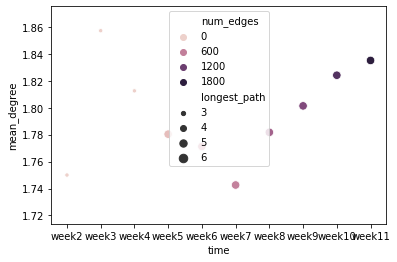

In [11]:
network_summaries
sns.scatterplot(x='time', y='mean_degree',hue='num_edges', size='longest_path', data=network_summaries)


In [12]:
# which_centrality='degree'
# heat=node_feature_time_agg.groupby(['province','time'])[which_centrality].max().reset_index().pivot(index='province', columns='time', values=which_centrality).fillna(0)
# ax=sns.heatmap(heat)
# ax.set(title=which_centrality )
# fig=ax.get_figure()
# fig.tight_layout() 

# fig.savefig("plots/"+which_centrality+"-province.png", dpi=300)


In [13]:
# #from mpl_toolkits.mplot3d import Axes3D
# fig=plt.figure()
# ax=fig.gca(projection='3d')
# ax.plot_trisurf(node_feature_time_agg['actual_age'],
#                 node_feature_time_agg['time'].apply(lambda x: int(x[-1])),
#                 node_feature_time_agg['degree'])

# fig=plt.figure()
# ax=fig.gca(projection='3d')
# ax.plot_trisurf(node_feature_time_agg['actual_age'],
#                 node_feature_time_agg['time'].apply(lambda x: int(x[-1])),
#                 node_feature_time_agg['betweenness'])

# fig=plt.figure()
# ax=fig.gca(projection='3d')
# ax.scatter(node_feature_time_agg['actual_age'],
#                 node_feature_time_agg['time'].apply(lambda x: int(x[-1])),
#                 node_feature_time_agg['degree'], c='skyblue')

# fig=plt.figure()
# ax=fig.gca(projection='3d')
# ax.scatter(node_feature_time_agg['actual_age'],
#                 node_feature_time_agg['time'].apply(lambda x: int(x[-1])),
#                 node_feature_time_agg['betweenness'], c='skyblue')

(Age, Province) and centrality

In [14]:
dfs=[]
for time in range(14,node_feature['timestamp'].max().days):
    _,_,node_feature_time,_ = get_measure(time, node_feature)
    node_feature_time['time']=time
    dfs.append(node_feature_time)
node_feature_time_agg=pd.concat(dfs)

In [15]:
which_centrality='degree'
# week='week5'
# ax=sns.regplot(x='actual_age', y=which_centrality, order=2,
#             data=node_feature_time_agg[node_feature_time_agg['time']==week])
# ax.set(xlabel='age', title=week, )
# fig=ax.get_figure()
# fig.tight_layout() 

# fig.savefig("plots/"+which_centrality+"-age-"+week+".png", dpi=300)


In [16]:
fig= px.scatter(node_feature_time_agg, y=which_centrality,animation_group='name',
          x='actual_age',
          range_y=[node_feature_time_agg[which_centrality].min(), node_feature_time_agg[which_centrality].max()+1],
          range_x=[1, 100],
           animation_frame='time',
           #size='relative_age',
           color='province',
           log_y=True,
           hover_data=['actual_age', 'sex','name','province'], title='Community transmission over time'
          )

fig.update_xaxes(title_text='age')
fig.update_yaxes(title_text=which_centrality)
fig.write_html("plots/"+which_centrality+"-age-province.html")

In [ ]:
#import plotly.graph_objects as go

# fig=go.Figure(data=[go.Surface(x=node_feature_time_agg['actual_age'].values,
#                 y=node_feature_time_agg['time'].apply(lambda x: int(x[-1])).values,
#                 z=node_feature_time_agg['degree'].values)])
# fig.update_layout(width=500, height=500)

In [ ]:
#node_feature['is_male']=node_feature['is_male'].astype(int)

## Connected component's characteristics over time

In [ ]:
# def get_network_time(timestamp):
#     #edges so far
#     edge_index_time=edge_index.loc[edge_index['timestamp'].dt.days<timestamp, ['infected_by', 'patient_id']]
#     elist= edge_index_time.values

#     #Creat network
#     G = nx.DiGraph()
#     G.add_edges_from(elist)
    
#     return G, elist

In [17]:
#Creat network
elist=edge_index.loc[:, ['infected_by', 'patient_id']].values
G = nx.DiGraph()
G.add_edges_from(elist)

In [18]:
#size of connected components
size_comp=[g.number_of_nodes() for g in nx.connected_component_subgraphs(G.to_undirected())]

(array([128.,   6.,   4.,   1.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([  2. ,  13.5,  25. ,  36.5,  48. ,  59.5,  71. ,  82.5,  94. ,
        105.5, 117. , 128.5, 140. , 151.5, 163. , 174.5, 186. , 197.5,
        209. , 220.5, 232. , 243.5, 255. , 266.5, 278. , 289.5, 301. ,
        312.5, 324. , 335.5, 347. , 358.5, 370. , 381.5, 393. , 404.5,
        416. , 427.5, 439. , 450.5, 462. , 473.5, 485. , 496.5, 508. ,
        519.5, 531. , 542.5, 554. , 565.5, 577. ]),
 <a list of 50 Patch objects>)

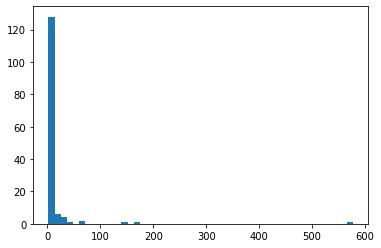

In [19]:
plt.hist(size_comp, bins=50)

In [20]:
cluster_size_threshold=20
memberships={}
for idx, g in enumerate(nx.connected_component_subgraphs(G.to_undirected())):
    if g.number_of_nodes()>=cluster_size_threshold:
        memberships[idx]=list(g.nodes)
        #print(nx.average_shortest_path_length(g))

In [21]:
node_feature['component']=''
edge_index['component']=''
for component, nodes in memberships.items():
    node_feature.loc[node_feature['id'].isin(nodes),'component']=component
    edge_index.loc[edge_index['patient_id'].isin(nodes), 'component']=component
    edge_index.loc[edge_index['infected_by'].isin(nodes), 'component']=component
    

In [22]:
node_feature.head()

,academy_ratio,actual_age,city,deceased,disease,elderly_alone_ratio,elderly_population_ratio,elementary_school_count,name,is_male,kindergarten_count,latitude,longitude,nursing_home_count,province,sex,timestamp,university_count,id,component
0,1.27,35.000000,Incheon,False,NaN,5.8,13.20,250.0,1400000001,False,403.0,37.456188,126.705920,4497.0,Incheon,female,0 days,7.0,611,0
21,NaN,33.201456,NaN,False,NaN,NaN,NaN,NaN,overseas inflow,True,NaN,NaN,NaN,NaN,NaN,NaN,0 days,NaN,1752,0
1,1.17,56.000000,Gangseo-gu,False,NaN,5.7,14.39,36.0,1000000001,True,56.0,37.551166,126.849506,1080.0,Seoul,male,3 days,1.0,0,0
2,1.88,54.000000,Goyang-si,False,NaN,5.2,12.82,84.0,2000000001,True,171.0,37.658363,126.831961,1608.0,Gyeonggi-do,male,6 days,2.0,777,0
3,1.39,56.000000,Pyeongtaek-si,False,NaN,5.6,12.13,58.0,2000000002,True,108.0,36.992293,127.112709,765.0,Gyeonggi-do,male,7 days,3.0,778,0


In [23]:
#manually examine how the components look like
for component_id in memberships.keys():
    print(component_id, node_feature[node_feature['component']==component_id]['name'][:100].values )
    

0 ['1400000001' 'overseas inflow' '1000000001' '2000000001' '2000000002'
 '1000000004' '1000000003' '1000000002' '1000000006' '1000000005'
 '1000000007' '5000000001' '2000000005' '1000000008' '1300000001'
 '1000000009' '1000000010' '2000000006' '1300000002' '2000000007'
 '1000000011' '5100000001' '1000000012' '2000000010' '2000000009'
 '2000000008' '2000000011' '1000000013' '1000000014' '2000000012'
 '1000000016' '1000000021' '1000000019' '1000000017' '2000000016'
 '2000000019' '1000000027' '2000000026' '6100000009' '1000000039'
 '1000000043' '1000000052' '1000000085' '1000000075' '1000000062'
 '1000000082' '3001000002' '1000000103' '1000000116' '2000000152'
 '1000000133' '2000000161' '1100000091' '1000000191' '2000000179'
 '1000000216' '1000000222' '1000000229' '1000000230' '2000000184'
 '1000000233' '1000000236' '1000000237' '2000000200' '1000000232'
 '1000000247' '1300000016' '1000000242' '2000000213' '1000000266'
 '5000000008' '2000000245' '6100000085' '2000000269' '1100000102'
 '4

In [24]:
#MANUALLY name the component
component_name = {0: 'Overseas Inflow',
                 2: 'Shincheonji Church',
                  75: 'Dongan Church',
                  80: 'Guro-gu Call Center',
                  14: 'Onchun Church',
                  24: 'Gym Facility in Cheonan-si',
                  90: 'Ministry of Oceans and Fisheries',
                  95: 'River of Grace Community Church',
                  109: 'Gunpo-si Nursing Home',
                  25: 'Cheonan/Asan-si',
                  136: 'Cheongdo Daenam Hospital Nursing Home',
                  140: 'Bonghwa Pureun Nursing Home' 
                 }

In [25]:
def get_path_length_comp_time(component, timestamp):
    elist_comp_t=edge_index.loc[(edge_index['timestamp'].dt.days<timestamp)&(edge_index['component']==component), ['patient_id','infected_by']].values
    G = nx.DiGraph()
    G.add_edges_from(elist_comp_t)
    
    if G.nodes == 0:
        return np.nan
    else:
        return np.mean([nx.average_shortest_path_length(g) for g in nx.connected_component_subgraphs(G.to_undirected())])

In [26]:
#Get each cluster's characteristics
comp_profile=[]
node_feature
for timestamp in range(14,node_feature['timestamp'].max().days):
    comp_profile_t=pd.concat([node_feature[node_feature['timestamp'].dt.days<timestamp].groupby('component')['id'].count(),
               node_feature[node_feature['timestamp'].dt.days<timestamp].groupby('component')['actual_age'].mean(),
               node_feature[node_feature['timestamp'].dt.days<timestamp].groupby('component')['is_male'].mean()
              ], axis=1)
    comp_profile_t['timestamp']=timestamp
    comp_profile_t.drop('', inplace=True)
    comp_profile_t['path_len']=[get_path_length_comp_time(component, timestamp) for component in comp_profile_t.index]
    comp_profile.append(comp_profile_t)


/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning:

Mean of empty slice.

/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning:

invalid value encountered in double_scalars



In [27]:
comp_profile_df = pd.concat(comp_profile).reset_index().sort_values(by=['timestamp', 'component'])
comp_profile_df['component_name']=comp_profile_df['component'].apply(lambda x: component_name[x])
comp_profile_df['circle_size']=(comp_profile_df['actual_age']-comp_profile_df['actual_age'].min())


In [28]:
fig= px.scatter(comp_profile_df, y='path_len',animation_group='component',
          x='id',
          range_y=[comp_profile_df['path_len'].min(), comp_profile_df['path_len'].max()+1],
          range_x=[1, comp_profile_df['id'].max()+10],
           animation_frame='timestamp',
           size='circle_size',
           color='is_male',
           log_x=True,
           hover_data=['component', 'component_name', 'actual_age', 'is_male'], title='Local Clusters over Time'
          )

fig.update_xaxes(title_text='Size of clusters')
fig.update_yaxes(title_text='Avg. Path Length')
fig.write_html("plots/community-transmission.html")

## Draw whole network

In [29]:
import sys
import os
import re

with open('plots/visualization/template.html', 'rt') as f:
    lines = f.readlines()

lines_to_print_before_network=[]
lines_to_print_after_network=[]
flag = 1

for i in range(len(lines)):
    if not lines[i].startswith('+----'):
        if (flag==1):
            lines_to_print_before_network.append(lines[i].rstrip())
        else:
            lines_to_print_after_network.append(lines[i].rstrip())
    else:
        print('yes, it hits')
        i += 1
        flag = 0
        
        
def write_subgraph_ggnetwork(filePath,node_list,edge_index):
    #filePath = './vargraph_' + 'k-'+str(KK)+'.txt'
    # As file at filePath is deleted now, so we should check if file exists or not not before deleting them
    if os.path.exists(filePath):
        os.remove(filePath)
    else:
        print("Can not delete the file as it doesn't exists")

    def w(input):
        return '"'+str(input)+'"'


    f  = open(filePath,"a")
    
    #f.write(''.join(lines_to_print_before_network))
    for line in lines_to_print_before_network:
        f.write(line + "\n")
    f.write("var graph = {"+"\n")
    f.write("\t nodes: ["+"\n")

    for i in node_list:
        f.write("{id:"+ w(i) + ", type:" + w(node2type[i]) + "}," +"\n")
        #f.write("{id:"+ w(i) + ", type:" + w('variable') + "}," +"\n")

    f.write("],"+"\n")

    f.write("\t links: ["+"\n")

#     for i in edge_index:
#         f.write("{source:"+ w(edge['source'][i]) \
#                 + ", target:" + w(edge['target'][i]) \
#                 + ", value:" + str(edge['value'][i])\
#                 + "}," +"\n")
    for i in range(len(edge_index)):
        f.write("{source:"+ w(edge_index['infected_by_name'][i]) \
                + ", target:" + w(edge_index['patient_id_name'][i]) \
                + ", value:" + str(1)\
                + "}," +"\n")

    f.write("]"+"\n")

    f.write("}"+"\n")
    #f.write(''.join(lines_to_print_after_network))
    for line in lines_to_print_after_network:
        f.write(line + "\n")
    f.close()

yes, it hits


In [30]:
node2type={str(row[0]):str(row[1]) for idx, row in node_feature[['name', 'component']].iterrows()}
edge_index['patient_id_name']=le.inverse_transform(edge_index['patient_id'])
edge_index['infected_by_name']=le.inverse_transform(edge_index['infected_by'])
#edge_index.reset_index(drop=True, inplace=True)
node_list=pd.unique(edge_index[['infected_by_name','patient_id_name']].astype(str).values.ravel('K'))





In [31]:
write_subgraph_ggnetwork('plots/visualization/whole-network.html',node_list,edge_index)